In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [18]:
# valid columns when high speed
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150')

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.024)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {            
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [6]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [7]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [8]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Red

In [9]:
df3 <- read.csv("../data/middle/sp2.csv", stringsAsFactors=FALSE)

In [10]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [11]:
allFeatures <- c(colnames(df3))
expr <- createFormula(invalids, allFeatures)

In [12]:
result <- CV(df3, expr, verbose=TRUE)
printRedRatios(df3)
printf("Red: Mean correct/predict = %f\n", result[2])
printf("Blue: Mean correct/predict = %f\n", result[3])
printf("CV value: %f", result[1])

Fold1
As for Red: correct/predict = 37/55 = 0.672727
As for Blue: correct/predict = 26/49 = 0.530612

Fold2
As for Red: correct/predict = 42/66 = 0.636364
As for Blue: correct/predict = 21/39 = 0.538462

Fold3
As for Red: correct/predict = 42/74 = 0.567568
As for Blue: correct/predict = 13/30 = 0.433333

Fold4
As for Red: correct/predict = 45/66 = 0.681818
As for Blue: correct/predict = 24/38 = 0.631579

Fold5
As for Red: correct/predict = 43/65 = 0.661538
As for Blue: correct/predict = 23/39 = 0.589744

Fold6
As for Red: correct/predict = 36/57 = 0.631579
As for Blue: correct/predict = 24/47 = 0.510638

Fold7
As for Red: correct/predict = 41/60 = 0.683333
As for Blue: correct/predict = 26/45 = 0.577778

Fold8
As for Red: correct/predict = 46/64 = 0.718750
As for Blue: correct/predict = 27/40 = 0.675000

Fold9
As for Red: correct/predict = 47/73 = 0.643836
As for Blue: correct/predict = 19/31 = 0.612903

Fold10
As for Red: correct/predict = 47/68 = 0.691176
As for Blue: correct/predict

In [13]:
fit3 <- rpart(expr, data=df3, method="class")

In [14]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.02115813

In [15]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AccelerationSpeed AheadDistance     AverageVelocity   CurveAverage     
 [5] DistSignal        Engine            Jerk              Pitch            
 [9] Speed             TimeHeadway       TimeToCollision  

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.073497      0   1.00000 1.00000 0.035602
2 0.050111      1   0.92650 0.99109 0.035562
3 0.026726      3   0.82628 0.89087 0.034964
4 0.024499      4   0.79955 0.87528 0.034845
5 0.021158      5   0.77506 0.87082 0.034810
6 0.013363      7   0.73274 0.87751 0.034862
7 0.011136     10   0.69265 0.87305 0.034827
8 0.010022     11   0.68151 0.89532 0.034996
9 0.010000     14   0.65033 0.90200 0.035044


In [16]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.07349666      0 1.0000000 1.0000000 0.03560167
2 0.05011136      1 0.9265033 0.9910913 0.03556206
3 0.02672606      3 0.8262806 0.8908686 0.03496369
4 0.02449889      4 0.7995546 0.8752784 0.03484484
5 0.02115813      5 0.7750557 0.8708241 0.03480957
6 0.01336303      7 0.7327394 0.8775056 0.03486225
7 0.01113586     10 0.6926503 0.8730512 0.03482728
8 0.01002227     11 0.6815145 0.8953229 0.03499635
9 0.01000000     14 0.6503341 0.9020045 0.03504427

Variable importance
      TimeHeadway             Speed     AheadDistance   AverageVelocity 
               17                17                14                 7 
  TimeToCollision AccelerationSpeed            Engine          RoadType 
                7                 6                 6                 6 
            Pitch      CurveAverage              Jerk             Curve 
                5                 

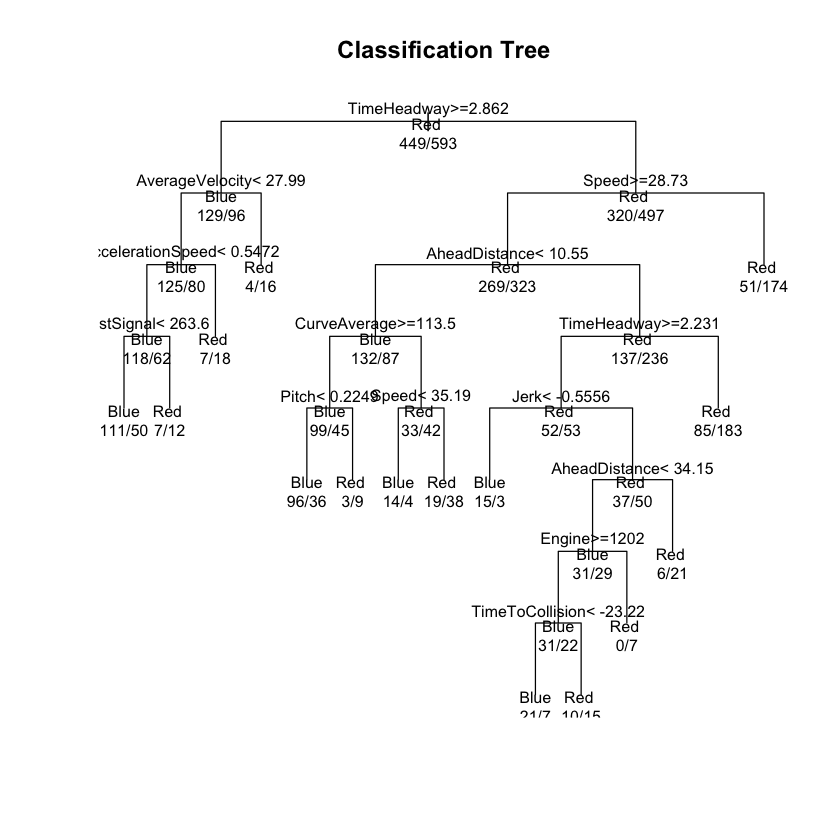

In [17]:
plot(fit3, uniform=TRUE, main="Classification Tree")
text(fit3, use.n=TRUE, all=TRUE, cex=.8)